In [1]:
from itertools import product

import jax.numpy as jnp
from math import prod
import numpy as np
import matplotlib.pyplot as plt
import netket as nk
from netket.operator.spin import sigmax, sigmaz
from scipy.sparse.linalg import eigsh

In [60]:
for i in range(N//2-1):
    print(2*i+1)
print(((N//2)-1)*2)

1
3
5
7
9
11
12


In [79]:


# System size and Hilbert space
N = 14
hi = nk.hilbert.Spin(s=1/2, N=N)

# Fixed parameter
lam1 = -1

# Parameter ranges
npts = 20
lam2_vals = np.linspace(-2, 2, npts)
lam3_vals = np.linspace(-2, 2, npts)  # lam3 = lam4
ZZ_corr_op = (sigmaz(hi, 0) * sigmaz(hi, N//2)).to_sparse()
SPT_corr_op = (sigmaz(hi, 0) * prod([sigmax(hi, 2*i+1) for i in range(N//4)]) * sigmaz(hi, (N//4)*2)).to_sparse()
X_corr_op = prod([sigmax(hi, 2*i+1) for i in range(N//4)]).to_sparse()
# Prepare storage
gap = np.zeros((npts, npts))
ZZ_corr = np.zeros((npts, npts))
SPT_corr = np.zeros((npts, npts))
X_corr = np.zeros((npts, npts))
psi_prev = None  # no guess for the very first diagonalization

# Loop over parameters
for i, lam3 in enumerate(lam3_vals):
    lam4 = lam3
    for j, lam2 in enumerate(lam2_vals):
        # Build Hamiltonian for this (lam2, lam3=lam4)
        H = sum([lam1 * sigmax(hi, site) for site in range(N)])
        #H -= sum([1e-6 * sigmaz(hi, site) for site in range(N)])
        H -= lam2  * sigmaz(hi, N-1) * sigmax(hi, 0) * sigmaz(hi, 1)
        H -= lam2  * sigmaz(hi, N-2) * sigmax(hi, N-1) * sigmaz(hi, 0)
        H -= sum([lam2 * sigmaz(hi, i) @ sigmax(hi, i+1) @ sigmaz(hi, i+2)
                  for i in range(N-2)])
        # note: using @ to compose operators
        H -= sum([lam3 * sigmaz(hi, 2*k-1) @ sigmaz(hi, 2*k+1)
                  for k in range(1, N//2)])
        H -= sum([lam4 * sigmaz(hi, 2*k) @ sigmaz(hi, 2*k+2)
                  for k in range(N//2-1)])
        H -= lam3 * sigmaz(hi, 0) @ sigmaz(hi, N-2)
        H -= lam3 * sigmaz(hi, 1) @ sigmaz(hi, N-1)
        # Diagonalize the two lowest eigenvalues
        sp_h = H.to_sparse()
        eigs, eig_vecs = eigsh(sp_h, k=2, which="SA", tol = 1e-9, ncv = 128)
        psi = eig_vecs[:, 0]
        gap[i, j] = eigs[1] - eigs[0]
        ZZ_corr[i, j] = psi @ (ZZ_corr_op.dot(psi))
        SPT_corr[i, j] = psi @ (SPT_corr_op.dot(psi))
        X_corr[i, j] = psi @ (X_corr_op.dot(psi))



/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2220546180.py:45: RuntimeWarning: divide by zero encountered in matmul
  ZZ_corr[i, j] = psi @ (ZZ_corr_op.dot(psi))
/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2220546180.py:45: RuntimeWarning: overflow encountered in matmul
  ZZ_corr[i, j] = psi @ (ZZ_corr_op.dot(psi))
/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2220546180.py:45: RuntimeWarning: invalid value encountered in matmul
  ZZ_corr[i, j] = psi @ (ZZ_corr_op.dot(psi))
/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2220546180.py:46: RuntimeWarning: divide by zero encountered in matmul
  SPT_corr[i, j] = psi @ (SPT_corr_op.dot(psi))
/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2220546180.py:46: RuntimeWarning: overflow encountered in matmul
  SPT_corr[i, j] = psi @ (SPT_corr_op.dot(psi))
/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2220546180.py:46: RuntimeWarning: 

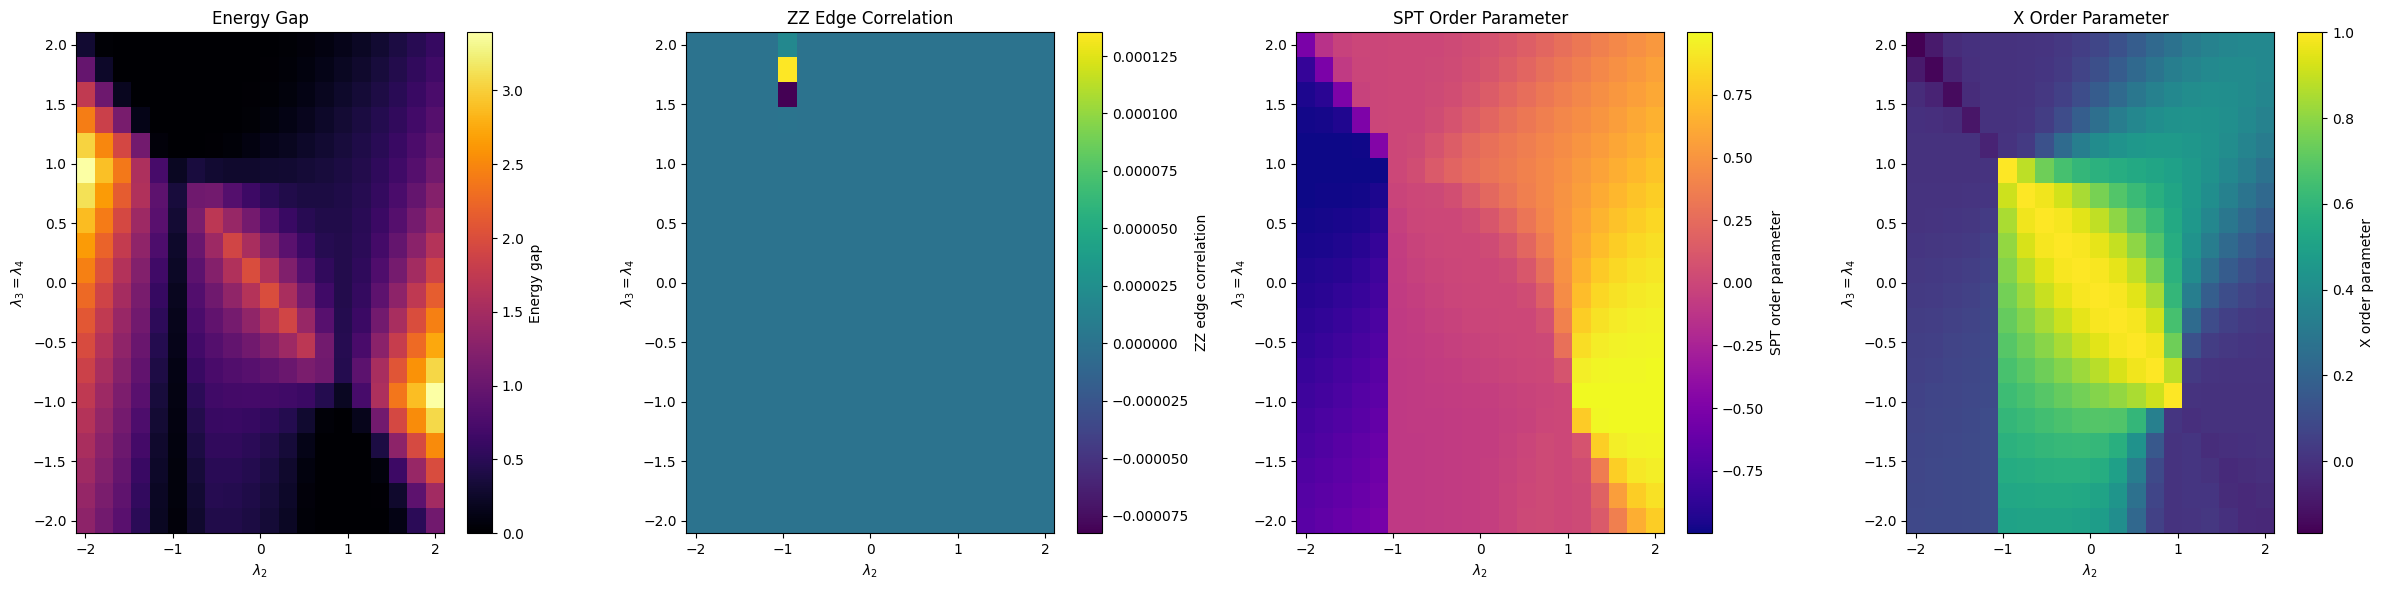

In [80]:
# Meshgrid for plotting
L2, L3 = np.meshgrid(lam2_vals, lam3_vals)

# Plot gap, ZZ, and SPT side by side
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Gap
pcm0 = axs[0].pcolormesh(L2, L3, gap, shading="auto", cmap="inferno")
fig.colorbar(pcm0, ax=axs[0], label="Energy gap")
axs[0].set_xlabel(r"$\lambda_2$")
axs[0].set_ylabel(r"$\lambda_3 = \lambda_4$")
axs[0].set_title(r"Energy Gap")

# ZZ edge correlation
pcm1 = axs[1].pcolormesh(L2, L3, ZZ_corr, shading="auto", cmap="viridis")
fig.colorbar(pcm1, ax=axs[1], label="ZZ edge correlation")
axs[1].set_xlabel(r"$\lambda_2$")
axs[1].set_ylabel(r"$\lambda_3 = \lambda_4$")
axs[1].set_title(r"ZZ Edge Correlation")

# String‐order (SPT) correlation
pcm2 = axs[2].pcolormesh(L2, L3, SPT_corr, shading="auto", cmap="plasma")
fig.colorbar(pcm2, ax=axs[2], label="SPT order parameter")
axs[2].set_xlabel(r"$\lambda_2$")
axs[2].set_ylabel(r"$\lambda_3 = \lambda_4$")
axs[2].set_title(r"SPT Order Parameter")

# X order parameter
pcm3 = axs[3].pcolormesh(L2, L3, X_corr, shading="auto", cmap="viridis")
fig.colorbar(pcm3, ax=axs[3], label="X order parameter")
axs[3].set_xlabel(r"$\lambda_2$")
axs[3].set_ylabel(r"$\lambda_3 = \lambda_4$")
axs[3].set_title(r"X Order Parameter")

plt.tight_layout()
plt.savefig("hw4_last_question(a)_periodic_plots.png", dpi = 300)
plt.show()


In [90]:
L2, L3 = np.meshgrid(lam2_vals, lam3_vals)
print(L2[0, 5], L3[0, 5], X_corr[0, 5])

-0.9473684210526316 -2.0 0.5038251188830952


In [91]:


# System size and Hilbert space
N = 14
hi = nk.hilbert.Spin(s=1/2, N=N)

# Fixed parameter
lam1 = -1
lam2 = -0.5
# Parameter ranges
npts = 20
lam3_vals = np.linspace(-2, 2, npts)
lam4_vals = np.linspace(-2, 2, npts)  # lam3 = lam4

ZZ_corr_op1 = (sigmaz(hi, 0) * sigmaz(hi, N-1)).to_sparse()
ZZ_corr_op2 = (sigmaz(hi, 0) * sigmaz(hi, N-2)).to_sparse()
ZZ_corr_op3 = (sigmaz(hi, 1) * sigmaz(hi, N-2)).to_sparse()
ZZ_corr_op4 = (sigmaz(hi, 1) * sigmaz(hi, N-1)).to_sparse()
SPT_corr_op = (sigmaz(hi, 0) * prod([sigmax(hi, 2*i+1) for i in range(N//2-1)]) * sigmaz(hi, (N//2-1)*2)).to_sparse()
#X_corr_op = prod([sigmax(hi, 2*i+1) for i in range(N//2-1)]).to_sparse()
# Prepare storage
gap = np.zeros((npts, npts))
ZZ_corr1 = np.zeros((npts, npts))
ZZ_corr2 = np.zeros((npts, npts))
ZZ_corr3 = np.zeros((npts, npts))
ZZ_corr4 = np.zeros((npts, npts))
SPT_corr = np.zeros((npts, npts))
#X_corr = np.zeros((npts, npts))
psi_prev = None  # no guess for the very first diagonalization

# Loop over parameters
for i, lam4 in enumerate(lam4_vals):
    for j, lam3 in enumerate(lam3_vals):
        # Build Hamiltonian for this (lam2, lam3=lam4)
        H = sum([-lam1 * sigmax(hi, site) for site in range(N)])
        #H -= sum([1e-6 * sigmaz(hi, site) for site in range(N)])
        H -= lam2  * sigmax(hi, 0) * sigmaz(hi, 1)
        H -= lam2  * sigmaz(hi, N-2) * sigmax(hi, N-1)
        H -= sum([lam2 * sigmaz(hi, i) @ sigmax(hi, i+1) @ sigmaz(hi, i+2)
                  for i in range(N-2)])
        # note: using @ to compose operators
        H -= sum([lam3 * sigmaz(hi, 2*k-1) @ sigmaz(hi, 2*k+1)
                  for k in range(1, N//2)])
        H -= sum([lam4 * sigmaz(hi, 2*k) @ sigmaz(hi, 2*k+2)
                  for k in range(N//2-1)])

        # Diagonalize the two lowest eigenvalues
        sp_h = H.to_sparse()
        eigs, eig_vecs = eigsh(sp_h, k=2, which="SA", tol = 1e-9, ncv = 128)
        psi = eig_vecs[:, 0]
        gap[i, j] = eigs[1] - eigs[0]
        ZZ_corr1[i, j] = psi @ (ZZ_corr_op1.dot(psi))
        ZZ_corr2[i, j] = psi @ (ZZ_corr_op2.dot(psi))
        ZZ_corr3[i, j] = psi @ (ZZ_corr_op3.dot(psi))
        ZZ_corr4[i, j] = psi @ (ZZ_corr_op4.dot(psi))
        SPT_corr[i, j] = psi @ (SPT_corr_op.dot(psi))



/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2437682328.py:50: RuntimeWarning: divide by zero encountered in matmul
  ZZ_corr1[i, j] = psi @ (ZZ_corr_op1.dot(psi))
/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2437682328.py:50: RuntimeWarning: overflow encountered in matmul
  ZZ_corr1[i, j] = psi @ (ZZ_corr_op1.dot(psi))
/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2437682328.py:50: RuntimeWarning: invalid value encountered in matmul
  ZZ_corr1[i, j] = psi @ (ZZ_corr_op1.dot(psi))
/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2437682328.py:51: RuntimeWarning: divide by zero encountered in matmul
  ZZ_corr2[i, j] = psi @ (ZZ_corr_op2.dot(psi))
/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2437682328.py:51: RuntimeWarning: overflow encountered in matmul
  ZZ_corr2[i, j] = psi @ (ZZ_corr_op2.dot(psi))
/var/folders/st/_7ytbd7d6j52sb_86yf95r8w0000gn/T/ipykernel_98338/2437682328.py:51: RuntimeWar

In [81]:
for i, lam4 in enumerate(lam4_vals):
    for j, lam3 in enumerate(lam3_vals):
        print(i, j)
        print(lam4, lam3)

0 0
-2.0 -2.0
0 1
-2.0 -1.7894736842105263
0 2
-2.0 -1.5789473684210527
0 3
-2.0 -1.368421052631579
0 4
-2.0 -1.1578947368421053
0 5
-2.0 -0.9473684210526316
0 6
-2.0 -0.736842105263158
0 7
-2.0 -0.5263157894736843
0 8
-2.0 -0.3157894736842106
0 9
-2.0 -0.10526315789473695
0 10
-2.0 0.10526315789473673
0 11
-2.0 0.3157894736842106
0 12
-2.0 0.5263157894736841
0 13
-2.0 0.7368421052631575
0 14
-2.0 0.9473684210526314
0 15
-2.0 1.1578947368421053
0 16
-2.0 1.3684210526315788
0 17
-2.0 1.5789473684210522
0 18
-2.0 1.789473684210526
0 19
-2.0 2.0
1 0
-1.7894736842105263 -2.0
1 1
-1.7894736842105263 -1.7894736842105263
1 2
-1.7894736842105263 -1.5789473684210527
1 3
-1.7894736842105263 -1.368421052631579
1 4
-1.7894736842105263 -1.1578947368421053
1 5
-1.7894736842105263 -0.9473684210526316
1 6
-1.7894736842105263 -0.736842105263158
1 7
-1.7894736842105263 -0.5263157894736843
1 8
-1.7894736842105263 -0.3157894736842106
1 9
-1.7894736842105263 -0.10526315789473695
1 10
-1.7894736842105263 0.

-2.0 -2.0 1.3054051488785774


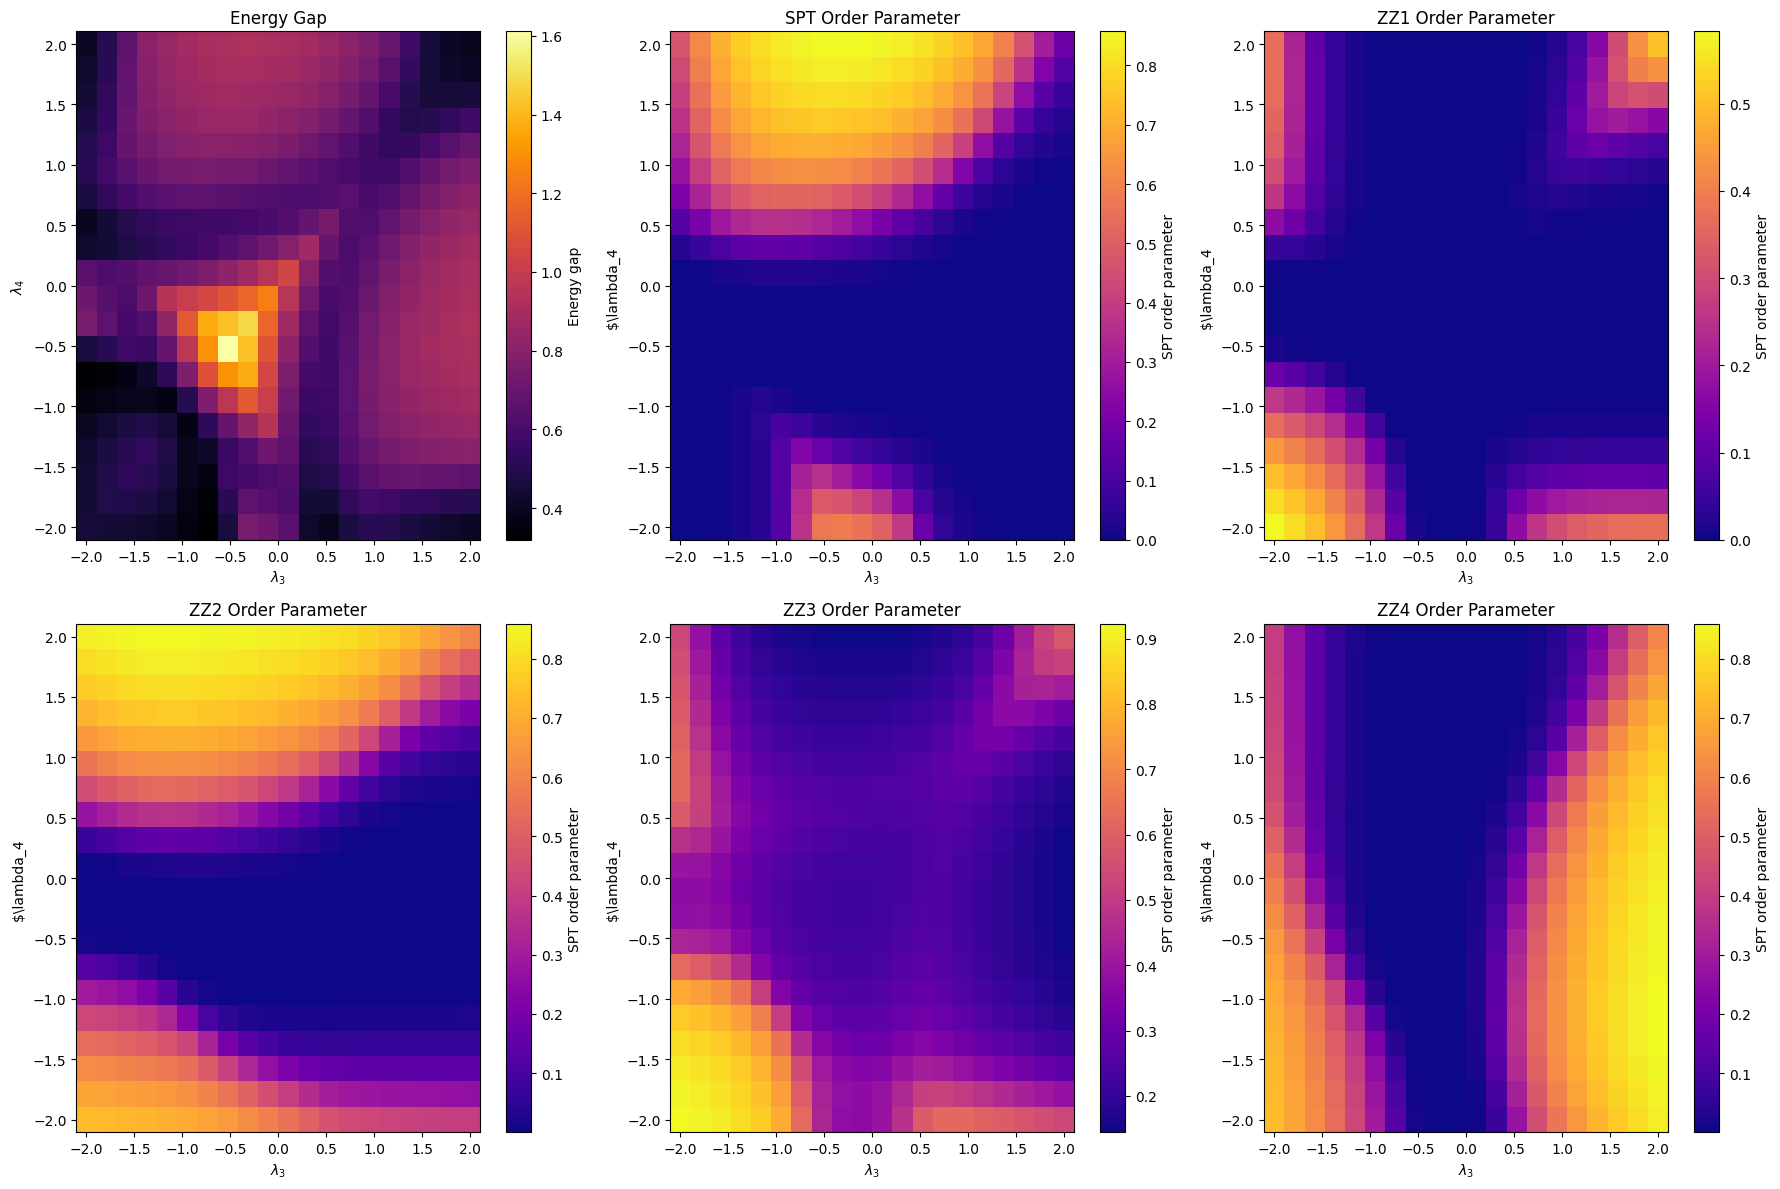

In [92]:
# Meshgrid for plotting
L2, L3 = np.meshgrid(lam3_vals, lam4_vals)

# Plot gap, ZZ, and SPT side by side
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Gap
pcm0 = axs[0, 0].pcolormesh(L2, L3, gap, shading="auto", cmap="inferno")
fig.colorbar(pcm0, ax=axs[0, 0], label="Energy gap")
axs[0, 0].set_xlabel(r"$\lambda_3$")
axs[0, 0].set_ylabel(r"$\lambda_4$")
axs[0, 0].set_title(r"Energy Gap")


# String‐order (SPT) correlation
pcm1 = axs[0, 1].pcolormesh(L2, L3, SPT_corr, shading="auto", cmap="plasma")
fig.colorbar(pcm1, ax=axs[0, 1], label="SPT order parameter")
axs[0, 1].set_xlabel(r"$\lambda_3$")
axs[0, 1].set_ylabel(r"$\lambda_4 ")
axs[0, 1].set_title(r"SPT Order Parameter")

# ZZ correlation
pcm3 = axs[0, 2].pcolormesh(L2, L3, ZZ_corr1, shading="auto", cmap="plasma")
fig.colorbar(pcm3, ax=axs[0, 2], label="SPT order parameter")
axs[0, 2].set_xlabel(r"$\lambda_3$")
axs[0, 2].set_ylabel(r"$\lambda_4 ")
axs[0, 2].set_title(r"ZZ1 Order Parameter")

# ZZ correlation
pcm4 = axs[1, 0].pcolormesh(L2, L3, ZZ_corr2, shading="auto", cmap="plasma")
fig.colorbar(pcm4, ax=axs[1, 0], label="SPT order parameter")
axs[1, 0].set_xlabel(r"$\lambda_3$")
axs[1, 0].set_ylabel(r"$\lambda_4 ")
axs[1, 0].set_title(r"ZZ2 Order Parameter")

pcm5 = axs[1, 1].pcolormesh(L2, L3, ZZ_corr3, shading="auto", cmap="plasma")
fig.colorbar(pcm5, ax=axs[1, 1], label="SPT order parameter")
axs[1, 1].set_xlabel(r"$\lambda_3$")
axs[1 ,1].set_ylabel(r"$\lambda_4 ")
axs[1, 1].set_title(r"ZZ3 Order Parameter")

pcm6 = axs[1, 2].pcolormesh(L2, L3, ZZ_corr4, shading="auto", cmap="plasma")
fig.colorbar(pcm6, ax=axs[1, 2], label="SPT order parameter")
axs[1, 2].set_xlabel(r"$\lambda_3$")
axs[1, 2].set_ylabel(r"$\lambda_4 ")
axs[1, 2].set_title(r"ZZ4 Order Parameter")

plt.tight_layout()
plt.savefig("hw4_last_question(d)_plots.png", dpi = 200)
plt.show()
